# GPT

----
* Inspired by Andrej Karpathy's ["Let's build GPT: from scratch, in code, spelled out."](https://www.youtube.com/watch?v=kCc8FmEb1nY)
* Supplementary links
    - [Attention is All You Need paper](https://arxiv.org/abs/1706.03762) from Google
    - OpenAI [GPT-3 Paper](https://arxiv.org/abs/2005.14165)
    - OpenAI [ChatGPT blog post](https://openai.com/blog/chatgpt/)
    - [nanoGPT](https://github.com/karpathy/nanoGPT)
    - [nanoGPT lecture](https://github.com/karpathy/ng-video-lecture)
    - Lambda GPU Cloud via [lambda labs](https://lambdalabs.com) provides GPU access for model training. The best and easiest way to spin up an on-demand GPU instance in the cloud is if you can ssh to: https://lambdalabs.com . If you prefer to work in notebooks, I think the easiest path today is [**Google Colab.**](https://colab.research.google.com/)
  

-----------
# Suggested Exercises
-----------
1. The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into [one class](#1) that processes all the heads in parallel, treating the heads as another batch dimension (answer is in `nanoGPT`).
2. Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? 
    - A fun advanced suggestion if you like: [train a GPT to do addition of two numbers, i.e. `a+b=c`.](#2) You may find it helpful to predict the digits of `c` in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of `train.bin`, `val.bin`. You may want to mask out the loss at the input positions of `a+b` that just specify the problem using `y=-1` in the targets (see `CrossEntropyLoss :ignore_index`. 
    - Does your Transformer learn to add? Once you have this: build a calculator clone in GPT, for all of `+-*/`. _Not an easy problem. You may need Chain of Thought traces_.)
3. [Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate.](#3) Can you obtain a lower validation loss by the use of pretraining?
4. Read some transformer papers and [implement one additional feature](#4) or change that people seem to use. Does it improve the performance of your GPT?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math, re
import random
from tqdm import tqdm
import csv, os


import time
import timeit
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-06-25 23:27:46--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.1'

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-06-25 23:27:46 (17.3 MB/s) - 'input.txt.1' saved [1115394/1115394]



In [3]:
print("length of dataset in characters: ", len(text), '\n')

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters in dataset",''.join(chars))
print("\nTotal number of unique characters in dataset:", vocab_size, '\n')

# let's look at the first 1000 characters
print('----------------------------------------------------------------')
print(text[:1000])

length of dataset in characters:  1115394 

Unique characters in dataset 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Total number of unique characters in dataset: 65 

----------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflic

<a id="1"></a>
# 1. Process All Heads in Parallel
----
Let's implement a single class that processes all the single heads in parallel via a vectorized version of combining the linear layers of each head into unified linear layers. It's essential the dimensions and shapes of the inputs and subsequent variables in the calculations are properly computed, monitored and matched up throughtout the whole implementation.

Multi-head attention entails applying multiple attentions in parallel and concatenating the results. It's basically just multiple attentions in parallel. Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

  > $$\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \text{...}, \text{head}_h )W^O$$
  $$\text{where }\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$
  
Where the projections are parameter matrices:
> $$W_i^Q \in \mathbb{R}^{ d_{model} \times\ {d_K} }$$
 $$W_i^K \in \mathbb{R}^{ d_{model} \times\ {d_K} }$$
 $$W_i^V \in \mathbb{R}^{ d_{model} \times\ {d_V} }$$
 $$W_i^O \in \mathbb{R}^{ hd_v \times\ d_{model}}$$
 $$ \text{with } {d_k} = {d_v} = d_{model}/h $$

<a id="a4"></a>
<center>
<img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" alt="multi-head attention" width="350"/>
</center>



In [4]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))
    
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head                                                     # nh        
        self.n_embd = n_embd
        self.head_size = n_embd // n_head                                        # hs
        self.scale = self.head_size ** -0.5

        # key, query, value projections for all heads, but in a batch & output projection
        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        self.out_proj = nn.Linear(n_embd, n_embd, bias=bias)
        
        # regularization: dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
#         self.dropout = nn.Dropout(dropout)

        # mask for self-attention
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        qkv = self.qkv_proj(x)
        qkv = qkv.view(B, T, self.n_head, 3 * self.head_size)
        
        # splits the qkv tensor into three tensors along the last dimension to get Q, K, V tensors
        q, k, v = qkv.chunk(3, dim=-1)                                           # (B, T, nh, hs)
        q = q.transpose(1, 2)                                                    # (B, nh, T, hs)
        k = k.transpose(1, 2)                                                    # (B, nh, T, hs)
        v = v.transpose(1, 2)                                                    # (B, nh, T, hs)
        
        # compute attention weights ('affinities')
        # self.scale = 1.0 / math.sqrt(k.size(-1))
        att_w = (q @ k.transpose(-2, -1)) * self.scale                           # (B, nh, T, hs) @ (B, nh, hs, T) -> (B, nh, T, T)
        att_w = att_w.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))   # (B, nh, T, T)
        att_w = F.softmax(att_w, dim=-1)                                         # (B, nh, T, T)
        att_w = self.attn_dropout(att_w)                                              # (B, nh, T, T)

        attn_output = att_w @ v                                                   # (B, nh, T, T) @ (B, nh, T, hs) -> (B, nh, T, hs)
        
        # re-assemble all head outputs side by side & final output projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)      # (B, T, n_embd)
        out_proj = self.resid_dropout(self.out_proj(attn_output))                 # (B, T, n_embd)
        return out_proj

class FeedFoward(nn.Module):
    """ a feedforward MLP"""

    def __init__(self, n_embd, activation_fn='relu'):
        super().__init__()
        self.in_proj = nn.Linear(n_embd, 4 * n_embd, bias=bias)   # fully connected
        self.activation_fn = activation_fn
        self.gelu = NewGELU() # nn.GELU() 
        self.relu = nn.ReLU()
        self.out_proj = nn.Linear(4 * n_embd, n_embd, bias=bias)  # projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.in_proj(x)
        if self.activation_fn == 'relu':
            x = self.relu(x) 
        elif self.activation_fn == 'gelu':
            x = self.gelu(x)
        x = self.out_proj(x)
        x = self.dropout(x)
        return x
    
class Block(nn.Module):
    def __init__(self, n_embd, n_head, activation_fn='relu'):
        super().__init__()
        self.ln1 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.attn = MultiHeadSelfAttention(n_embd, n_head)
        self.ln2 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.ffwd = FeedFoward(n_embd, activation_fn=activation_fn)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class GPT(nn.Module):

    def __init__(self, do_addition=False, activation_fn='relu'):
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
        
        if do_addition:
            self.ndigit = ndigit
            self.vocab_size = 10  # digits 0..9
            self.block_size = 3*ndigit + 1 - 1
            
        # transformer
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, activation_fn=activation_fn) for _ in range(n_layer)])
        self.ln_f = LayerNorm(n_embd, bias=bias)   # nn.LayerNorm(n_embd) # final layer norm
        
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.num_parameters = self.get_num_params() 
        print("number of parameters: %.2fM" % (self.num_parameters/1e6,))

        self.apply(self._init_weights)   # init all the weights
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('out_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
                
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.shape
        assert T <= block_size, f"Cannot forward sequence of length {T}, block size is only {block_size}"
        pos = torch.arange(T, dtype=torch.long, device=device).unsqueeze(0)       # (1,T)
        
        # idx and targets are both (B,T) tensor of integers [C = n_embd]
        tok_emb = self.token_embedding_table(idx)                                 # (B,T,C)
        pos_emb = self.position_embedding_table(pos)                              # (T,C)
        x = tok_emb + pos_emb                                                     # (B,T,C)
        x = self.dropout(x)
        x = self.blocks(x)                                                        # (B,T,C)
        x = self.ln_f(x)                                                          # (B,T,C)
        logits = self.lm_head(x)                                                  # (B,T,vocab_size)

        if targets is None:
            loss = None
#         else:
#             B, T, C = logits.shape
#             logits = logits.view(B*T, C)
#             targets = targets.view(B*T)
#             loss = F.cross_entropy(logits, targets)
#         else:
#             logits_flat = logits.view(-1, logits.size(-1))                        # (B*T, vocab_size)
#             targets_flat = targets.view(-1)                                       # (B*T,)
#             loss = F.cross_entropy(logits_flat, targets_flat)
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=True, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context (idx) is growing too long we must crop it at block_size
            idx_len = idx.size(1)                                  # get length of idx, T, from idx shape (B, T)
            idx_cut = idx[:, -block_size:]                         # crop idx to the last block_size tokens
            idx_cond = idx if idx_len <= block_size else idx_cut   # crop idx to the last block_size tokens if it exceeds block_size
            
            logits, loss = self(idx_cond)                          # get the predictions
            logits = logits[:, -1, :] / temperature                # (B, C) pluck the logits of the last time step and scale by temperature. logits[all batches, last timestamp, all channels]
            
            # if top_k is specified, the logits are filtered to keep only the top k values.
            if top_k is not None:
                top_k = min(top_k, logits.size(-1))                # ensures top_k does not exceed the number of logits.
                top_v, _ = torch.topk(logits, top_k)               # selects the top k logits
                logits[logits < top_v[:, [-1]]] = -float('Inf')    # sets all logits that are not in the top k to -inf, effectively removing them from consideration when sampling.
            
            probs = F.softmax(logits, dim=-1)                      # (B, C) - apply softmax to turn logits to probabilities
            
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) - sample next token from the prob. distribution
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)       # (B, 1) - take the most likely token if not sampling
            idx = torch.cat((idx, idx_next), dim=1)                # (B, T+1) - append sampled index to the running sequence
        return idx

In [40]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


def train_model(model, learning_rate, max_iters, eval_interval):
    train_losses = []
    val_losses = []
    epochs = []

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(model)
            train_losses.append(losses['train'])#.item())
            val_losses.append(losses['val'])#.item())
            epochs.append(iter)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return epochs, train_losses, val_losses


def plot_loss(epochs, train_losses, val_losses, rot=45):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the training and validation losses
    ax.plot(epochs, train_losses, marker='o', label='Training Loss')
    ax.plot(epochs, val_losses, marker='o', label='Validation Loss')

    ax.set_xlabel('Iterations', fontsize=14)                       # Set the x-axis label
    ax.set_ylabel('Loss', fontsize=14)                             # Set the y-axis label
    ax.set_xticks(epochs)                                          # Set the x-axis ticks
    ax.set_xticklabels(epochs, rotation=rot, fontsize=12)         # Set the x-axis ticks' labels
    ax.tick_params(axis='y', labelsize=12)                         # Set the y-axis ticks' labels
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))   # Set the y-axis format
    ax.set_title('Training and Validation Losses', fontsize=16)    # Set the title
    ax.legend(fontsize=12)                                         # Add a legend
    ax.grid(linestyle='--', alpha=0.5)                             # Add grid lines
    plt.tight_layout()                                             # Adjust the spacing between subplots
    plt.show()                                                     # Display the plot

    
def generate_text(model, context, max_new_tokens=1000, temp=1.0, do_sample=True, top_k=None):
    # generate from the model
    model.eval()
    m = model.to(device)
#     context = torch.zeros((1, 1), dtype=torch.long, device=device)
    generated = m.generate(context, max_new_tokens=max_new_tokens,temperature=temp, do_sample=do_sample, top_k=top_k)
    print(decode(m.generate(context, max_new_tokens=max_new_tokens,temperature=temp)[0].tolist()))
    #open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=max_new_tokens)[0].tolist()))
    model.train()

number of parameters: 10.77M
step 0: train loss 4.1783, val loss 4.1769
step 500: train loss 2.3632, val loss 2.3776
step 1000: train loss 1.5666, val loss 1.7580
step 1500: train loss 1.3402, val loss 1.5627
step 2000: train loss 1.2429, val loss 1.5012
step 2500: train loss 1.1727, val loss 1.4805
step 3000: train loss 1.1138, val loss 1.4742
step 3500: train loss 1.0536, val loss 1.4835
step 4000: train loss 1.0006, val loss 1.5063
step 4500: train loss 0.9396, val loss 1.5337
step 4999: train loss 0.8858, val loss 1.5517
step 5000: train loss 0.8863, val loss 1.5597


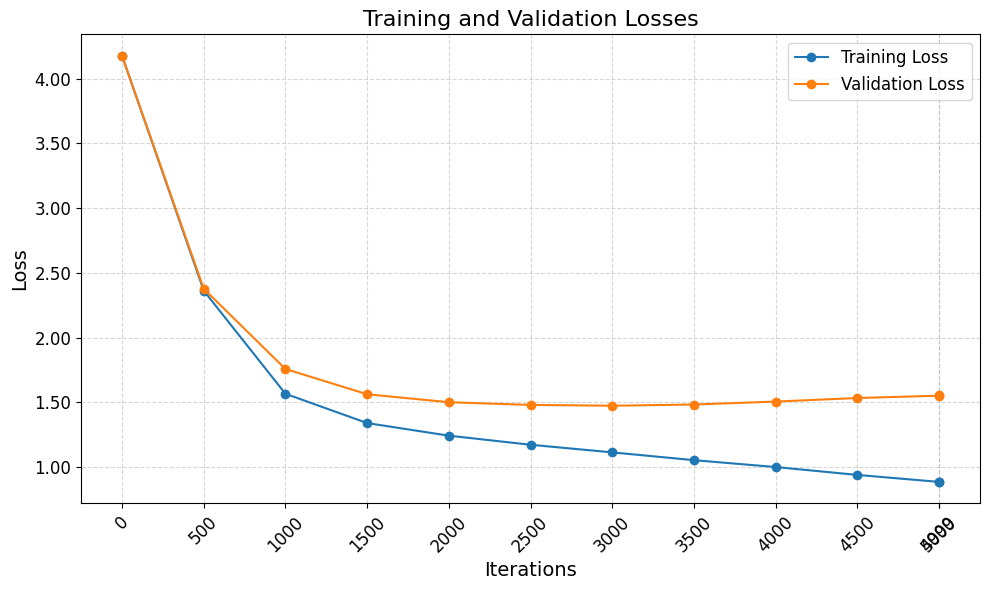


Sir, proud sir, awhile, and I am in harm;
Therefore tell me for thy mirth, then let your grace
In action, I know myself in all arms.

KING RICHARD II:
Then play thee, my lord; inding thy true blood
Makes the devilise heart of this deep dead?
Now, for thy house, then thou steal'st worm about thy iron,
That is not thy sword's face to men's country's mind;
The word is he doth turn'd my fortune;
And thou shalt be spoke for my study strength.

GLOUCESTER:
Go to; and with me have join'd the tempest sort
Which stand'st in the child: the trumpets must substance
Of my execution, the pretty state, he would feel me,
Since she was a sleeping prey sound!

KING EDWARD IV:
Why, then a thousand soldiers of death,
And that then not be done, where evil.
But where is thy lord?
I do pray thee, now down great with her!
Hath she for this son to be a true bash
And with her life endured at thy bones!
O, which dreams a thousand throats trumpets!
Speak thy summers that smooth bids me well show
Shall desting th

In [6]:
# hyperparameters
batch_size = 64 #16       #32 how many independent sequences will we process in parallel?
block_size = 256 #32       #8 what is the maximum context length for predictions?
max_iters = 5000      #3000
eval_interval = 500   #300
learning_rate = 6e-4 #1e-3  #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 #64           #32  (n_head * batch_size)
n_head = 6 #4                   (n_embd/batch_size)
n_layer = 6 #4
dropout = 0.2 #0.0
bias = False  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
# ------------

#--------------------------------------------------------------------------------------
start_time = time.time()
#--------------------------------------------------------------------------------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
model = GPT(activation_fn='gelu').to(device)
epochs, train_losses, val_losses = train_model(model, learning_rate, max_iters, eval_interval)
plot_loss(epochs, train_losses, val_losses)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generate_text(model, context, max_new_tokens=1000, temp=0.8, do_sample=True, top_k=None)

#--------------------------------------------------------------------------------------
end_time = time.time()
# Print elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
#--------------------------------------------------------------------------------------



<a id="2"></a>
# 2. Train GPT to perform **addition**
----
Let's implement and train a GPT model to do addition of two numbers,`a+b=c`. 

### Expected loss in making a prediction, assuming a uniform distribution, is: 
$$-ln(\frac{1}{vocab\_size})=-ln(\frac{1}{10})=2.3026$$ <br>

With `vocab_size = len('0123456789') = 10`. So, this should guide us in terms of a reasonable starting point for loss.

----

In [23]:
vocab_size = len('0123456789') # 10
# vocab_size, -np.log(1/vocab_size), -np.log(1/10)   # vocab_size = 10
print(f'The expected loss given a uniform distribution \
for a vocabulary size of {vocab_size} is {-np.log(1/vocab_size):.4f}')

The expected loss given a uniform distribution for a vocabulary size of 10 is 2.3026


### Functions Needed

In [24]:
class AdditionDataset(Dataset):
    def __init__(self, ndigit, split, rng_num=1337):
        self.ndigit = ndigit
        self.split = split
        num = (10**ndigit)**2  # Total number of possible addition problems
        rng = torch.Generator()
        rng.manual_seed(rng_num)
        perm = torch.randperm(num, generator=rng)  # Random permutation of all possible indices

        # Define the sizes of train, validation, and test splits
        num_val = int(num * 0.05) # min(int(num * 0.15), 500)  # Validation set size
        num_test = int(num * 0.05) # min(int(num * 0.15), 500)  # Test set size
        num_train = num - num_val - num_test  # Training set size

        if split == 'train':
            self.ixes = perm[:num_train]
        elif split == 'val':
            self.ixes = perm[num_train:num_train + num_val]
        elif split == 'test':
            self.ixes = perm[num_train + num_val:num_train + num_val + num_test]
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")

    def __len__(self):
        return self.ixes.nelement()  # Number of examples

    def __getitem__(self, idx):
        idx = self.ixes[idx].item()  # Get the index
        nd = 10**self.ndigit
        a = idx // nd  # First number
        b = idx % nd  # Second number
        c = a + b  # Sum
        astr = f'{a:0{self.ndigit}d}'  # String representation of a
        bstr = f'{b:0{self.ndigit}d}'  # String representation of b
        cstr = f'{c:0{self.ndigit+1}d}'[::-1]  # Reversed string of sum
#         print(f'{astr} + {bstr} = {cstr[::-1]}')
        render = astr + bstr + cstr  # Concatenate strings
        dix = [int(s) for s in render]  # Convert to list of digits
        x = torch.tensor(dix[:-1], dtype=torch.long)  # Exclude the last digit
        y = torch.tensor(dix[1:], dtype=torch.long)  # Shifted digits
        y[:self.ndigit * 2 - 1] = -1  # Mask positions corresponding to a and b
        return x, y

    def get_vocab_size(self):
        return 10  # digits 0..9

    def get_block_size(self):
        return 3 * self.ndigit + 1 - 1  # Sequence length excluding the last digit


In [25]:
def train_addition_model(model, train_loader, val_loader, batch_size, ndigit, max_epochs):

    train_losses = []
    val_losses = []
    epochs_list = []

    for epoch in range(1,max_epochs+1):
        model.train()
        epoch_train_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Calculate average train loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits, loss = model(x, y)
                val_loss += loss.item()
                y_pred = logits[:, -ndigit-1:, :].argmax(dim=-1)
                y_true = y[:, -ndigit-1:]
                correct += (y_pred == y_true).all(dim=1).sum().item()
                total += y_true.shape[0]

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        epochs_list.append(epoch)

        print(f"Epoch {epoch}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {correct/total*100:.2f}%")
    return model, epochs_list, train_losses, val_losses


def plot_losses(epochs, train_losses, losses, split='val'):
    plt.figure(figsize=(10, 6))
    if split == 'val':
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
        plt.plot(range(1, epochs + 1), losses, label='Validation Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses Over Time')
    elif split =='test':
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
        plt.plot(range(1, epochs + 1), losses, label='Test Loss', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses Over Time')
    else:
        raise ValueError("Split must be 'val', or 'test'")
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, epochs + 1, max(1, epochs // 10)))  # Set x-axis ticks
    plt.tight_layout()
    plt.show()
    

def plot_losses2(epochs, train_losses, losses, split='val', rot=0):
    plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots(figsize=(10, 6))
    if split == 'val':
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, losses, label='Validation Loss', marker='o')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('Training and Validation Losses Over Time', fontsize=16)
    elif split =='test':
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, losses, label='Test Loss', marker='o')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('Training and Validation Losses Over Time', fontsize=16)
    else:
        raise ValueError("Split must be 'val', or 'test'")
    plt.legend()
    plt.grid(True)
    x_axis_labels = range(1, epochs[-1], max(1, epochs[-1] // 10))
#     plt.xticks(x_axis_labels)                                      # Set x-axis ticks
    ax.set_xticks(x_axis_labels)                                   # Set the x-axis tick locations
    ax.set_xticklabels(x_axis_labels, rotation=rot, fontsize=12)   # Set the x-axis ticks' labels
    y_axis_labels = np.arange(0, max(train_losses[0], val_losses[0]) +0.25,  0.25) #np.arange(0, 2, 0.25)
#     plt.yticks(y_axis_labels)
    ax.set_yticks(y_axis_labels)                                   # Set the y-axis tick locations
    ax.set_yticklabels(y_axis_labels, fontsize=12)                 # Set the x-axis ticks' labels
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))   # Set the y-axis format
    plt.tight_layout()
    plt.show()

In [26]:
def eval_split(model, dataset, ndigit, device, batch=100, temp=0.8, num_mistakes_to_see=5, max_batches=None):
    model.eval()                                                                 # Set model to evaluation mode
    results = []                                                                 # List to store results (correct/incorrect)
    mistakes_printed = 0                                                         # Counter to track printed mistakes
    
    # Create a tensor of factors [10^ndigit, 10^(ndigit-1), ..., 10^0]
    factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]])             # Factors for decoding digits to integers
    factors = factors.to(model.parameters().__next__().device)                   # Move factors to appropriate device
    loader = DataLoader(dataset, batch_size=batch, shuffle=True)                               # DataLoader for iterating over dataset in batches(default: num_workers=0, drop_last=False)

    with torch.no_grad():                                                        # Turn off gradients for evaluation
        for b, (x, y) in enumerate(loader):                                      # Iterate over batches in the DataLoader
            x = x.to(model.parameters().__next__().device)                       # Move input data to appropriate device
            d1d2 = x[:, :ndigit*2]                                               # Extract first two digits from input sequence
            d1d2d3 = model.generate(d1d2, ndigit+1, temperature=temp)            # Generate the rest of the sequence using the model 
            d3 = d1d2d3[:, -(ndigit+1):].flip(1)                                 # Reverse and extract the last digit from the generated sequence
            d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)                       # Decode first input digit to integer
            d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)               # Decode second input digit to integer
            d3i_pred = (d3 * factors).sum(1)                                     # Decode predicted third digit to integer
            d3i_gt = d1i + d2i                                                   # Calculate ground truth sum (third digit)
            correct = (d3i_pred == d3i_gt).cpu()                                 # Check correctness of predictions
            for i in range(x.size(0)):                                           # Loop over batch examples
                results.append(int(correct[i]))                                  # Append correct predictions to results list
                if not correct[i] and mistakes_printed < num_mistakes_to_see:    # only print up to 5 (or specified) mistakes to get a sense
                    mistakes_printed += 1
                    print(f"GPT claims that {d1i[i]} + {d2i[i]} = {d3i_pred[i]} but gt is {d3i_gt[i]}")  # Print mistake details
            if max_batches is not None and b+1 >= max_batches:                  
                break                                                            # Stop if max_batches is specified and reached

    rt = torch.tensor(results, dtype=torch.float)                                # Convert results list to tensor
    accuracy = 100 * rt.mean()                                                   # Calculate accuracy
    print(f"\nFinal score: {rt.sum()}/{len(results)} = {accuracy:.2f}% correct") # Print final accuracy
    model.train()                                                                # set model back to training mode
    return rt.sum(), accuracy                                                    # Return total correct and accuracy


In [27]:
def test_addition(model, ndigit, incorrect_to_see=10, runs=3000):
    model.eval()
    correct = 0
    incorrect_printed = 0
    for _ in range(runs):
        a = random.randint(0, 10**ndigit - 1)
        b = random.randint(0, 10**ndigit - 1)
        c = a + b
        problem = f"{a:0{ndigit}d}{b:0{ndigit}d}"
        context = torch.tensor([int(d) for d in problem], dtype=torch.long).unsqueeze(0)
        context = context.to(model.parameters().__next__().device)

        with torch.no_grad():
            generated = model.generate(context, max_new_tokens=ndigit+1, temperature=0.8)
        predicted = ''.join([str(d.item()) for d in generated[0, -ndigit-1:]])[::-1]
        actual = f"{c:0{ndigit+1}d}"
                
        if predicted == actual:
            correct += 1
        elif predicted != actual and incorrect_printed < incorrect_to_see:
            incorrect_printed += 1
#             print(context)
            print(f"Incorrect Addition: {a} + {b} = ?, Generated: {predicted}, Actual: {actual}")
#             print('--------------')
    accuracy = correct / runs * 100
#     print(f"Accuracy: {accuracy:.2f}%")
    print(f"\nFinal score: {correct}/{runs} = {accuracy:.2f}% Accuracy\n")
    model.train()
    return accuracy # f'Correct/Total: {correct}/{runs}', accuracy


def simple_test_addition(model, ndigit, num_tests=20, correct_to_see=20):
    model.eval()
    correct = 0
    ct = 0
    for _ in range(num_tests):
        a = random.randint(0, 10**ndigit - 1)
        b = random.randint(0, 10**ndigit - 1)
        c = a + b
        problem = f"{a:0{ndigit}d}{b:0{ndigit}d}"
        x = torch.tensor([int(d) for d in problem], dtype=torch.long).unsqueeze(0)
        x = x.to(model.parameters().__next__().device) # Move x to the same device as the model

        with torch.no_grad():
            generated = model.generate(x, max_new_tokens=ndigit+1, temperature=0.7)
        generated_solution = ''.join(str(d.item()) for d in generated[0, -ndigit-1:])[::-1]
        actual_solution = f"{c:0{ndigit+1}d}"
        if ct < correct_to_see:
            print(f"Problem: {a} + {b} = ?, Generated: {generated_solution}, Actual: {actual_solution}")
            ct +=1
        if generated_solution == actual_solution:
            correct += 1
            
    accuracy = correct / num_tests * 100
    print(f"\nFinal score: {correct}/{num_tests} =  {accuracy:.2f}% Accuracy\n")
    model.train()
    return accuracy

---
## Model Training & Evaluation for $2$ digit addition: `ab + cd`
----
1. Specify hyperparameters
2. Shuffle & split data into train, test and validation sets
3. Load data via `DataLoader`
4. Define model & optimizer
5. Train model
6. Get final training & validation loss
7. Plot train and validation losses over time
8. Get the average test loss and test accuracy from test dataset
9. Generate new addition data and measure test accuracy of generated predicted sums

number of parameters: 0.79M
Epoch 1/20, Train Loss: 1.5902, Validation Loss: 1.5354, Validation Accuracy: 1.00%
Epoch 2/20, Train Loss: 1.1899, Validation Loss: 0.5963, Validation Accuracy: 46.40%
Epoch 3/20, Train Loss: 0.5246, Validation Loss: 0.2549, Validation Accuracy: 79.20%
Epoch 4/20, Train Loss: 0.3539, Validation Loss: 0.1859, Validation Accuracy: 82.60%
Epoch 5/20, Train Loss: 0.2237, Validation Loss: 0.0847, Validation Accuracy: 95.20%
Epoch 6/20, Train Loss: 0.1668, Validation Loss: 0.0323, Validation Accuracy: 99.00%
Epoch 7/20, Train Loss: 0.1377, Validation Loss: 0.0118, Validation Accuracy: 100.00%
Epoch 8/20, Train Loss: 0.1138, Validation Loss: 0.0111, Validation Accuracy: 100.00%
Epoch 9/20, Train Loss: 0.1064, Validation Loss: 0.0228, Validation Accuracy: 99.00%
Epoch 10/20, Train Loss: 0.0988, Validation Loss: 0.0200, Validation Accuracy: 98.40%
Epoch 11/20, Train Loss: 0.0919, Validation Loss: 0.0045, Validation Accuracy: 100.00%
Epoch 12/20, Train Loss: 0.0867, 

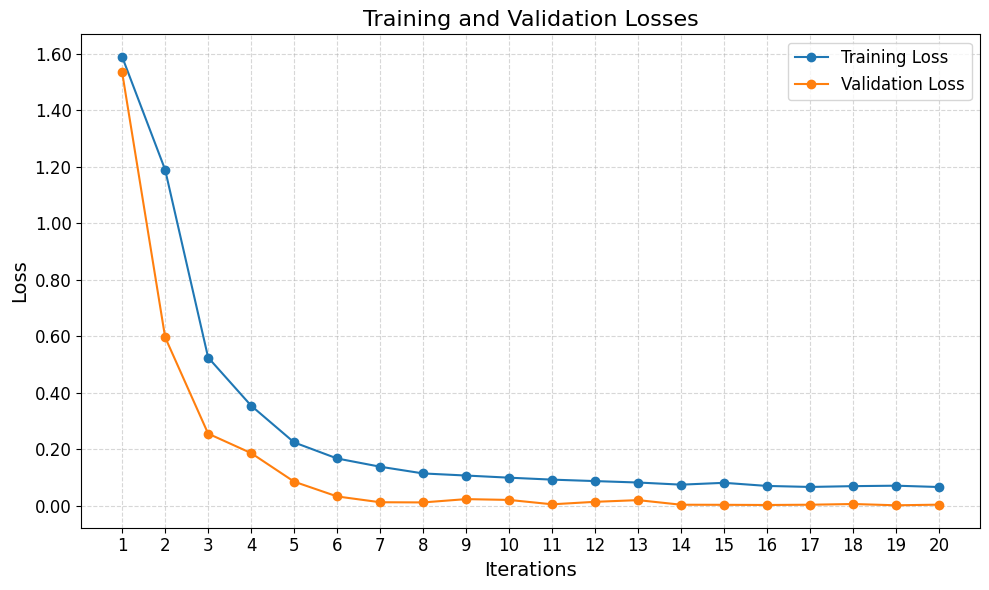

CPU times: user 1min 2s, sys: 496 ms, total: 1min 3s
Wall time: 1min 3s


In [28]:
%%time
# Hyperparameters
ndigit = 2
vocab_size = 10  # digits 0..9
block_size = 3*ndigit + 1 - 1
n_layer = 4
n_head = 4                # (n_embd / batch_size)
n_embd = 128 # 2048              # (n_head * batch_size)
dropout = 0.1
learning_rate = 5e-4
max_epochs = 20
batch_size = 32 # 512
bias = False

train_dataset = AdditionDataset(ndigit, split='train')
val_dataset = AdditionDataset(ndigit, split='val')
test_dataset = AdditionDataset(ndigit, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = GPT(do_addition=True, activation_fn='gelu').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model, epochs_completed, train_losses, val_losses = train_addition_model(model, train_loader, val_loader, batch_size, ndigit, max_epochs)

print(f"\nTraining completed after {epochs_completed[-1]} epochs.")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Plot the learning curves
plot_loss(epochs_completed, train_losses, val_losses, rot=0)

In [29]:
# After training is complete, evaluate the model on the test dataset
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        test_loss += loss.item()
        y_pred = logits[:, -ndigit-1:, :].argmax(dim=-1)
        y_true = y[:, -ndigit-1:]
        test_correct += (y_pred == y_true).all(dim=1).sum().item()
        test_total += y_true.shape[0]

# Calculate average test loss and test accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total * 100

print(f"No. of test samples: {len(test_loader)} \nAvg. Test Loss: {avg_test_loss:.4f} \nTest Accuracy: {test_accuracy:.2f}%")
# model.train()

No. of test samples: 16 
Avg. Test Loss: 0.0037 
Test Accuracy: 100.00%


In [30]:
with torch.no_grad():
    print("Final Test split evaluation:")
    eval_split(model, test_dataset, ndigit, device, batch=batch_size, temp=0.8, num_mistakes_to_see=10, max_batches=None)

Final Test split evaluation:
GPT claims that 87 + 81 = 158 but gt is 168

Final score: 499.0/500 = 99.80% correct


In [31]:
%%time
with torch.no_grad():
    print("Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    test_addition(model, ndigit, incorrect_to_see=10, runs=10000)

Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:

Incorrect Addition: 10 + 52 = ?, Generated: 063, Actual: 062
Incorrect Addition: 61 + 50 = ?, Generated: 112, Actual: 111
Incorrect Addition: 15 + 35 = ?, Generated: 040, Actual: 050
Incorrect Addition: 37 + 6 = ?, Generated: 033, Actual: 043
Incorrect Addition: 93 + 94 = ?, Generated: 177, Actual: 187
Incorrect Addition: 88 + 2 = ?, Generated: 080, Actual: 090
Incorrect Addition: 87 + 98 = ?, Generated: 175, Actual: 185
Incorrect Addition: 91 + 60 = ?, Generated: 152, Actual: 151
Incorrect Addition: 15 + 35 = ?, Generated: 040, Actual: 050
Incorrect Addition: 95 + 80 = ?, Generated: 165, Actual: 175

Final score: 9970/10000 = 99.70% Accuracy

CPU times: user 1min 38s, sys: 31.5 ms, total: 1min 38s
Wall time: 1min 38s


In [32]:
%%time
with torch.no_grad():
    print("Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    simple_test_addition(model, ndigit, num_tests=3000)

Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:

Problem: 95 + 19 = ?, Generated: 114, Actual: 114
Problem: 55 + 23 = ?, Generated: 078, Actual: 078
Problem: 15 + 29 = ?, Generated: 044, Actual: 044
Problem: 8 + 60 = ?, Generated: 068, Actual: 068
Problem: 19 + 86 = ?, Generated: 105, Actual: 105
Problem: 7 + 7 = ?, Generated: 014, Actual: 014
Problem: 74 + 77 = ?, Generated: 151, Actual: 151
Problem: 16 + 23 = ?, Generated: 039, Actual: 039
Problem: 78 + 71 = ?, Generated: 149, Actual: 149
Problem: 42 + 66 = ?, Generated: 108, Actual: 108
Problem: 95 + 5 = ?, Generated: 100, Actual: 100
Problem: 48 + 39 = ?, Generated: 087, Actual: 087
Problem: 9 + 64 = ?, Generated: 073, Actual: 073
Problem: 58 + 91 = ?, Generated: 149, Actual: 149
Problem: 72 + 34 = ?, Generated: 106, Actual: 106
Problem: 88 + 11 = ?, Generated: 099, Actual: 099
Problem: 87 + 67 = ?, Generated: 154, Actual: 154
Problem: 8 + 75 = ?, Generated: 083, Actual: 083
Problem: 

---
## Model Training & Evaluation for $3$ digit addition: `abc + def`
----

1. Specify hyperparameters
2. Shuffle & split data into train, test and validation sets
3. Load data via `DataLoader`
4. Define model & optimizer
5. Train model
6. Get final training & validation loss
7. Plot train and validation losses over time
8. Get the average test loss and test accuracy from test dataset
9. Generate new addition data and measure test accuracy of generated predicted sums

number of parameters: 0.01M
Epoch 1/10, Train Loss: 1.2735, Validation Loss: 1.1515, Validation Accuracy: 1.00%
Epoch 2/10, Train Loss: 1.1966, Validation Loss: 1.1521, Validation Accuracy: 1.07%
Epoch 3/10, Train Loss: 1.1909, Validation Loss: 1.1515, Validation Accuracy: 1.08%
Epoch 4/10, Train Loss: 1.1881, Validation Loss: 1.1515, Validation Accuracy: 0.96%
Epoch 5/10, Train Loss: 1.1863, Validation Loss: 1.1515, Validation Accuracy: 1.06%
Epoch 6/10, Train Loss: 1.1848, Validation Loss: 1.1516, Validation Accuracy: 0.95%
Epoch 7/10, Train Loss: 1.1835, Validation Loss: 1.1515, Validation Accuracy: 0.96%
Epoch 8/10, Train Loss: 1.1826, Validation Loss: 1.1516, Validation Accuracy: 1.05%
Epoch 9/10, Train Loss: 1.1818, Validation Loss: 1.1514, Validation Accuracy: 0.98%
Epoch 10/10, Train Loss: 1.1806, Validation Loss: 1.1514, Validation Accuracy: 1.01%

Training completed after 10 epochs.
Final train loss: 1.1806
Final validation loss: 1.1514


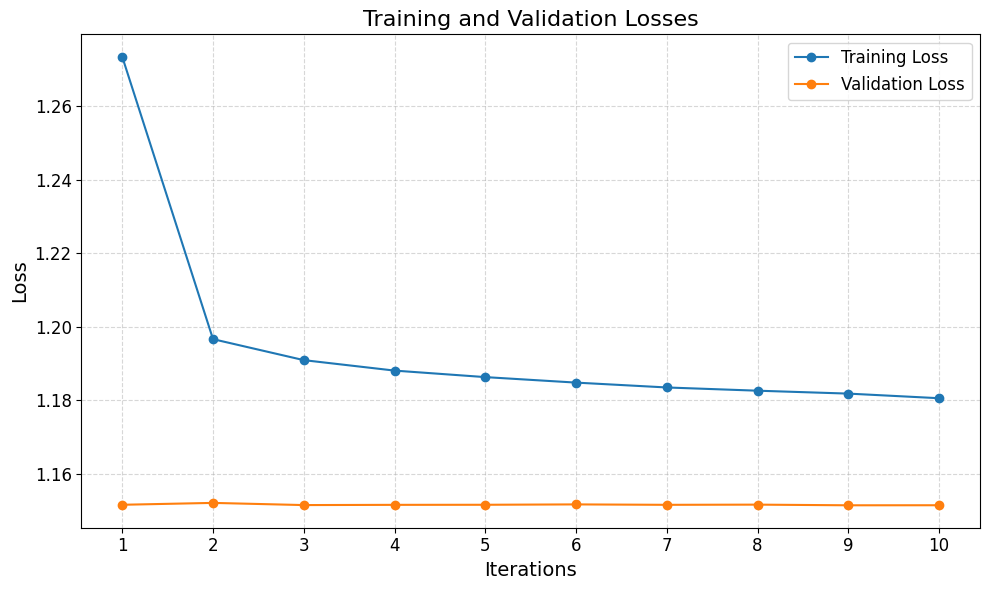

No. of test samples: 1563 
Avg. Test Loss: 1.1514 
Test Accuracy: 0.94%

Final Validation split evaluation:
GPT claims that 787 + 774 = 1991 but gt is 1561
GPT claims that 749 + 661 = 1420 but gt is 1410
GPT claims that 32 + 575 = 797 but gt is 607
GPT claims that 833 + 728 = 1971 but gt is 1561
GPT claims that 986 + 582 = 1518 but gt is 1568
GPT claims that 842 + 660 = 1142 but gt is 1502
GPT claims that 969 + 59 = 838 but gt is 1028
GPT claims that 527 + 90 = 1157 but gt is 617
GPT claims that 338 + 267 = 625 but gt is 605
GPT claims that 717 + 738 = 1115 but gt is 1455

Final score: 501.0/50000 = 1.00% correct
----------------------------------------

Final Test split evaluation:
GPT claims that 398 + 220 = 1268 but gt is 618
GPT claims that 170 + 888 = 488 but gt is 1058
GPT claims that 390 + 804 = 1184 but gt is 1194
GPT claims that 552 + 956 = 1928 but gt is 1508
GPT claims that 677 + 335 = 662 but gt is 1012
GPT claims that 504 + 293 = 697 but gt is 797
GPT claims that 827 + 259

In [33]:
%%time
# Main execution
if __name__ == "__main__":
    # Hyperparameters
    ndigit = 3
    vocab_size = 10  # digits 0..9
    block_size = 3*ndigit + 1 - 1
    n_layer = 1 #4 #6
    n_head = 1 #4 #6                # (n_embd / batch_size)
    n_embd = 32 #128 #384            # (n_head * batch_size)
    dropout = 0.1
    learning_rate = 5e-4
    max_epochs = 10 #20
    batch_size = 32 #64
    bias = False 
    
    train_dataset = AdditionDataset(ndigit, split='train')
    val_dataset = AdditionDataset(ndigit, split='val')
    test_dataset = AdditionDataset(ndigit, split='test')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    #--------------------------------------------------------------------------------------
    start_time = time.time()
    #--------------------------------------------------------------------------------------

    model = GPT(do_addition=True, activation_fn='gelu').to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model, epochs_completed, train_losses, val_losses = train_addition_model(model, train_loader, val_loader, batch_size, ndigit, max_epochs)

    print(f"\nTraining completed after {epochs_completed[-1]} epochs.")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"Final validation loss: {val_losses[-1]:.4f}")


    # Plot the learning curves
    plot_loss(epochs_completed, train_losses, val_losses, rot=0)
    
    # After training is complete, evaluate the model on the test dataset
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, y)
            test_loss += loss.item()
            y_pred = logits[:, -ndigit-1:, :].argmax(dim=-1)
            y_true = y[:, -ndigit-1:]
            test_correct += (y_pred == y_true).all(dim=1).sum().item()
            test_total += y_true.shape[0]

    # Calculate average test loss and test accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total * 100

    print(f"No. of test samples: {len(test_loader)} \nAvg. Test Loss: {avg_test_loss:.4f} \nTest Accuracy: {test_accuracy:.2f}%\n")
    model.train()

    # Final evaluation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_dataset = AdditionDataset(ndigit, split='val', rng_num=12)
    test_dataset = AdditionDataset(ndigit, split='test', rng_num=12)

#     model.eval()
    with torch.no_grad():
        print("Final Validation split evaluation:")
        eval_split(model, val_dataset, ndigit, device, batch=100, temp=0.8, num_mistakes_to_see=10, max_batches=None)
        print('----------------------------------------')
        print("\nFinal Test split evaluation:")
        eval_split(model, test_dataset, ndigit, device, batch=100, temp=0.8, num_mistakes_to_see=10, max_batches=None)

#     model.train()
    
    #--------------------------------------------------------------------------------------
    end_time = time.time()
    # Print elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")
    #--------------------------------------------------------------------------------------

In [34]:
%%time
with torch.no_grad():
    print("Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    test_addition(model, ndigit, incorrect_to_see=10, runs=10000)

Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:

Incorrect Addition: 872 + 48 = ?, Generated: 1030, Actual: 0920
Incorrect Addition: 453 + 342 = ?, Generated: 0885, Actual: 0795
Incorrect Addition: 455 + 328 = ?, Generated: 1303, Actual: 0783
Incorrect Addition: 21 + 17 = ?, Generated: 0298, Actual: 0038
Incorrect Addition: 199 + 764 = ?, Generated: 1023, Actual: 0963
Incorrect Addition: 862 + 855 = ?, Generated: 1737, Actual: 1717
Incorrect Addition: 713 + 363 = ?, Generated: 0846, Actual: 1076
Incorrect Addition: 167 + 804 = ?, Generated: 0391, Actual: 0971
Incorrect Addition: 47 + 83 = ?, Generated: 0640, Actual: 0130
Incorrect Addition: 998 + 36 = ?, Generated: 1054, Actual: 1034

Final score: 92/10000 = 0.92% Accuracy

CPU times: user 46.6 s, sys: 11.5 ms, total: 46.6 s
Wall time: 46.6 s


In [35]:
%%time
with torch.no_grad():
    print("Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    simple_test_addition(model, ndigit, num_tests=3000)

Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:

Problem: 882 + 899 = ?, Generated: 1211, Actual: 1781
Problem: 692 + 964 = ?, Generated: 1386, Actual: 1656
Problem: 392 + 421 = ?, Generated: 0783, Actual: 0813
Problem: 661 + 816 = ?, Generated: 1597, Actual: 1477
Problem: 550 + 408 = ?, Generated: 0858, Actual: 0958
Problem: 849 + 663 = ?, Generated: 1882, Actual: 1512
Problem: 713 + 597 = ?, Generated: 0960, Actual: 1310
Problem: 596 + 354 = ?, Generated: 0980, Actual: 0950
Problem: 690 + 779 = ?, Generated: 1089, Actual: 1469
Problem: 952 + 806 = ?, Generated: 1958, Actual: 1758
Problem: 565 + 139 = ?, Generated: 0264, Actual: 0704
Problem: 107 + 625 = ?, Generated: 0352, Actual: 0732
Problem: 13 + 808 = ?, Generated: 1021, Actual: 0821
Problem: 647 + 914 = ?, Generated: 1871, Actual: 1561
Problem: 192 + 867 = ?, Generated: 1029, Actual: 1059
Problem: 703 + 461 = ?, Generated: 0614, Actual: 1164
Problem: 997 + 88 = ?, Generated: 1145, 

---
## Model Training & Evaluation for $3$ digit addition: `abc + def` $\rightarrow$ Increase Model Size
----
1. Specify **hyperparameters**
2. Shuffle & split data into train, test and validation sets
3. Load data via `DataLoader`
4. Define model & optimizer
5. Train model
6. Get final training & validation loss
7. Plot train and validation losses over time
8. Get the average test loss and test accuracy from test dataset
9. Generate new addition data and measure test accuracy of generated predicted sums

number of parameters: 0.10M
Epoch 1/5, Train Loss: 0.2700, Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch 2/5, Train Loss: 0.1336, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 3/5, Train Loss: 0.0655, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 4/5, Train Loss: 0.0273, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch 5/5, Train Loss: 0.0268, Validation Loss: 0.0000, Validation Accuracy: 100.00%

Training completed after 5 epochs.
Final train loss: 0.0268
Final validation loss: 0.0000


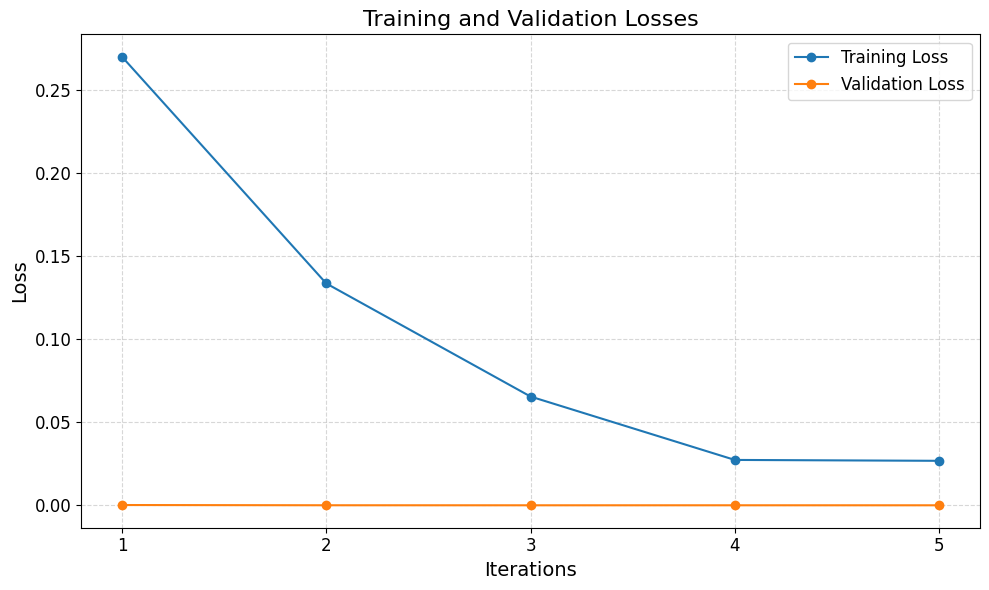

Final Test split evaluation:

Final score: 50000.0/50000 = 100.00% correct
CPU times: user 15min 50s, sys: 6.99 s, total: 15min 57s
Wall time: 16min 5s


GPT(
  (token_embedding_table): Embedding(10, 64)
  (position_embedding_table): Embedding(9, 64)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm()
      (attn): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=64, out_features=192, bias=False)
        (out_proj): Linear(in_features=64, out_features=64, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm()
      (ffwd): FeedFoward(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (gelu): NewGELU()
        (relu): ReLU()
        (out_proj): Linear(in_features=256, out_features=64, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm()
      (attn): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=64, out_features=192, bias=False)
        (out_proj): Linear(in_featu

In [41]:
%%time
# Hyperparameters
ndigit = 3
vocab_size = 10  # digits 0..9
block_size = 3*ndigit + 1 - 1
n_layer = 2 #4
n_head = 2 #4                # (n_embd / batch_size)
n_embd = 64 #128 # 2048              # (n_head * batch_size)
dropout = 0.1
learning_rate = 5e-4
max_epochs = 5 #10 #20
batch_size = 32 # 512
bias=False


train_dataset = AdditionDataset(ndigit, split='train')
val_dataset = AdditionDataset(ndigit, split='val')
test_dataset = AdditionDataset(ndigit, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = GPT(do_addition=True, activation_fn='gelu').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model, epochs_completed, train_losses, val_losses = train_addition_model(model, train_loader, val_loader, batch_size, ndigit, max_epochs)

print(f"\nTraining completed after {epochs_completed[-1]} epochs.")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Plot the learning curves
plot_loss(epochs_completed, train_losses, val_losses, rot=0)

# model evaluation using test data
model.eval()
with torch.no_grad():
    print("Final Test split evaluation:")
    eval_split(model, test_dataset, ndigit, device, batch=batch_size, temp=0.8, num_mistakes_to_see=10, max_batches=None)
model.train()

In [42]:
%%time
# After training is complete, evaluate the model on the test dataset
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        test_loss += loss.item()
        y_pred = logits[:, -ndigit-1:, :].argmax(dim=-1)
        y_true = y[:, -ndigit-1:]
        test_correct += (y_pred == y_true).all(dim=1).sum().item()
        test_total += y_true.shape[0]

# Calculate average test loss and test accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total * 100

print(f"No. of test samples: {len(test_loader)} \nAvg. Test Loss: {avg_test_loss:.4f} \nTest Accuracy: {test_accuracy:.2f}%")

No. of test samples: 1563 
Avg. Test Loss: 0.0000 
Test Accuracy: 100.00%
CPU times: user 4.89 s, sys: 1.95 ms, total: 4.89 s
Wall time: 4.87 s


In [43]:
%%time
with torch.no_grad():
    print("Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    test_addition(model, ndigit, incorrect_to_see=10, runs=10000)

Robust Case - Generate new addition data and measure test accuracy of generated predicted sums:


Final score: 10000/10000 = 100.00% Accuracy

CPU times: user 1min 14s, sys: 21.2 ms, total: 1min 14s
Wall time: 1min 14s


In [44]:
%%time
with torch.no_grad():
    print("Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:\n")
    simple_test_addition(model, ndigit, num_tests=10000)

Simple Case - Generate new addition data and measure test accuracy of generated predicted sums:

Problem: 436 + 871 = ?, Generated: 1307, Actual: 1307
Problem: 97 + 232 = ?, Generated: 0329, Actual: 0329
Problem: 359 + 826 = ?, Generated: 1185, Actual: 1185
Problem: 163 + 851 = ?, Generated: 1014, Actual: 1014
Problem: 647 + 342 = ?, Generated: 0989, Actual: 0989
Problem: 831 + 901 = ?, Generated: 1732, Actual: 1732
Problem: 831 + 344 = ?, Generated: 1175, Actual: 1175
Problem: 691 + 779 = ?, Generated: 1470, Actual: 1470
Problem: 526 + 35 = ?, Generated: 0561, Actual: 0561
Problem: 206 + 640 = ?, Generated: 0846, Actual: 0846
Problem: 165 + 444 = ?, Generated: 0609, Actual: 0609
Problem: 410 + 804 = ?, Generated: 1214, Actual: 1214
Problem: 402 + 92 = ?, Generated: 0494, Actual: 0494
Problem: 620 + 134 = ?, Generated: 0754, Actual: 0754
Problem: 135 + 98 = ?, Generated: 0233, Actual: 0233
Problem: 278 + 475 = ?, Generated: 0753, Actual: 0753
Problem: 786 + 324 = ?, Generated: 1110, Ac

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataset = AdditionDataset(ndigit, split='val', rng_num=123)
test_dataset = AdditionDataset(ndigit, split='test', rng_num=123)

#     model.eval()
with torch.no_grad():
    print("Final Validation split evaluation:")
    eval_split(model, val_dataset, ndigit, device, batch=100, temp=0.8, num_mistakes_to_see=10, max_batches=None)
    print('----------------------------------------')
    print("\nFinal Test split evaluation:")
    eval_split(model, test_dataset, ndigit, device, batch=100, temp=0.8, num_mistakes_to_see=10, max_batches=None)

Final Validation split evaluation:

Final score: 50000.0/50000 = 100.00% correct
----------------------------------------

Final Test split evaluation:

Final score: 50000.0/50000 = 100.00% correct
